Clone of Andrej Karpathy's micrograd, made while following along with his lecture: https://www.youtube.com/watch?v=VMj-3S1tku0

In [574]:
import math
import numpy as np
from graphviz import Digraph
from matplotlib import pyplot as plt

**Value Class**

In [575]:
def infixExprLabel(value):
    return f"({value._op.join([str(p.label) for p in value._prev])})" if value._prev else str(value.data)

def prefixExprLabel(value):
    return f"{value._op} {' '.join([str(p.label) for p in value._prev])} " if value._prev else str(value.data)

class Value:
    def __init__(self, data, _prev=(), _op='', label=None):
        self.data = data
        self.grad = 0
        self._prev = _prev
        self._op = _op
        self.label = label if label else infixExprLabel(self)

    def __repr__(self):
        return f"{type(self).__name__}(data={self.data:5f} grad={self.grad:5f})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        return AddOp(self, other)

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        return MulOp(self, other)

    def __pow__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        return PowerOp(self, other)

    def __sub__(self, other):
        return self + -1 * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __radd__(self, other): # other + self
        return self + other
    
    def __rsub__(self, other): # other - self
        return self - other
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __rtruediv__(self, other): # other / self
        return self / other

    def __neg__(self):
        return -1 * self
    
    def tanh(self):
        return TanhOp(self)
    
    def _backwards(self):
        pass

class BinaryOp(Value):
    def __init__(self, data, a, b, _op):
        super().__init__(data, (a, b), _op)
        self.a = a
        self.b = b

class PowerOp(BinaryOp):
    def __init__(self, a, b):
        super().__init__(a.data ** b.data, a, b, '**')

    def _backwards(self):
        self.a.grad += self.b.data * self.a.data**(self.b.data-1) * self.grad
        # self.b.grad += (math.log(self.a.data) * self.a.data**self.b.data) * self.grad

class AddOp(BinaryOp):
    def __init__(self, a, b):
        super().__init__(a.data + b.data, a, b, '+')

    def _backwards(self):
        self.a.grad += self.grad
        self.b.grad += self.grad

class MulOp(BinaryOp):
    def __init__(self, a, b):
        super().__init__(a.data * b.data, a, b, '*')

    def _backwards(self):
        self.a.grad += self.b.data * self.grad
        self.b.grad += self.a.data * self.grad

class TanhOp(Value):
    def __init__(self, a):
        tanh = (math.exp(2*a.data) - 1) / (math.exp(2*a.data) + 1)
        super().__init__(tanh, (a,), 'tanh', f"tanh({a.label})")
        self.a = a

    def _backwards(self):
        self.a.grad += (1 - self.data**2) * self.grad


**Basic Neural Net**

In [576]:
def dot(x, y):
    assert len(x) == len(y), "shape mismatch x: {}, y: {}".format(len(x), len(y))
    sum = x[0] * y[0]
    for i in range(1, len(x)):
        sum += x[i] * y[i]
    return sum

class Neuron:
    def __init__(self, in_features):
        self.weights = [Value(w, label='w') for w in np.random.randn(in_features)]
        self.bias = Value(np.random.randn(), label='b')
        self.activation = Value(0.)

    def activate(self, x):
        self.activation = (dot(self.weights, x) + self.bias)#.tanh()
        self.activation.label = 'a'
        return self.activation

class FullyConnectedLayer:
    def __init__(self, in_features, out_features):
        self.neurons = [Neuron(in_features) for _ in range(out_features)]

    def activate(self, x):
        return [neuron.activate(x) for neuron in self.neurons]

class Network:
    def __init__(self, input_size, hidden_size, output_size):
        self.layers = [
            FullyConnectedLayer(input_size, hidden_size), 
            FullyConnectedLayer(hidden_size, output_size)
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer.activate(x)
        return x

**draw_graph()**

In [577]:
def draw_graph(node, connectToNodeId=None, graph=None):
    if graph is None:
        graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodeId = str(id(node))

    # draw me:
    label = f"{node.label} | {node.data:.5f} | grad: {node.grad:0.5f}" if node.label else f"{node.data:.5f} | grad: {node.grad:0.5f}"
    graph.node(nodeId, label = label, shape='record')

    if connectToNodeId:
        graph.edge(nodeId, connectToNodeId)

    # if result of operator, draw operator node:
    if node._op:
        opNodeId = str(id(node)) + node._op
        graph.node(opNodeId, label=node._op, shape='circle') # draw operator node
        graph.edge(opNodeId, nodeId) # connect me to it

        for p in node._prev:
            draw_graph(p, opNodeId, graph)

    return graph

**Drawing the numeric derivative**

In [578]:
"""
h = Value(0.001, label='h')

# L = -2 * (2.0 * -3.0 + 10.0)
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L1'
L1 = L

#     F     A     B      C
# L = -2 * (2.0 * -3.0 + 10.0)
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
e = e + h; e.label = 'derr_e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L2'
L2 = L

x = (L2 - L1)/h; x.label = 'numeric derivative'
# draw_graph(x)
"""

"\nh = Value(0.001, label='h')\n\n# L = -2 * (2.0 * -3.0 + 10.0)\na = Value(2.0, label='a')\nb = Value(-3.0, label='b')\nc = Value(10.0, label='c')\ne = a * b; e.label = 'e'\nd = e + c; d.label = 'd'\nf = Value(-2.0, label='f')\nL = d * f; L.label = 'L1'\nL1 = L\n\n#     F     A     B      C\n# L = -2 * (2.0 * -3.0 + 10.0)\na = Value(2.0, label='a')\nb = Value(-3.0, label='b')\nc = Value(10.0, label='c')\ne = a * b; e.label = 'e'\ne = e + h; e.label = 'derr_e'\nd = e + c; d.label = 'd'\nf = Value(-2.0, label='f')\nL = d * f; L.label = 'L2'\nL2 = L\n\nx = (L2 - L1)/h; x.label = 'numeric derivative'\n# draw_graph(x)\n"

**Backprop**

In [579]:
def topological_sort(node, ordered=[]):
    if node not in ordered:
        for p in node._prev:
            topological_sort(p, ordered)
        ordered.append(node)
    return ordered

def backprop(node):
    node.grad = 1
    for n in reversed(topological_sort(node)):
        n._backwards()

def zero_grad(node):
    for n in topological_sort(node):
        n.grad = 0

**Training Loop**

In [580]:
def MSE(y, y_hat):
    return (y_hat - y)**2

def average_loss(net, loss_function, xs, ys):
    loss = 0
    for i in range(len(xs)):
        output = net.forward(xs[i])
        loss += loss_function(ys[i], output[0])
    return loss / len(xs)

def optimize(net, learning_rate):
    for layer in net.layers:
        for neuron in layer.neurons:
            for weight in neuron.weights:
                weight.data -= weight.grad * learning_rate
            neuron.bias.data -= neuron.bias.grad * learning_rate

def train(net, xs, ys, epochs=1000, learning_rate=0.01):
    losses = []
    for epoch in range(epochs):
        loss = average_loss(net, MSE, xs, ys)
        print(f"Epoch #{epoch} loss={loss.data}")
        losses += [loss.data]
        zero_grad(loss)
        backprop(loss)
        optimize(net, learning_rate)
    return losses

**Example**

In [581]:
xs = np.random.randn(10, 8)
ys = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
net = Network(input_size=8, hidden_size=16, output_size=1)

print("expected:")
print(ys)

loss = average_loss(net, MSE, xs, ys)
print(f"Initial predictions (loss={loss.data})")

predictions = [net.forward(x)[0].data for x in xs]
print(predictions)

# one training step:
# zero_grad(loss)
# backprop(loss)
# optimize(net, 0.01)

# training loop:
training_loss = train(net, xs, ys, epochs=20, learning_rate=0.01)

loss = average_loss(net, MSE, xs, ys)
print(f"Final predictions (loss={loss.data})")

predictions = [net.forward(x)[0].data for x in xs]
print(predictions)


expected:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Initial predictions (loss=55.778839947435145)
[-7.472862811090709, 3.009640390780826, 6.2839199625906845, -8.582935252129149, -8.42243113655671, 1.1346937513216133, 3.9175234779059798, 2.6933383389270356, 16.970352037399582, 6.707047213117504]
Epoch #0 loss=55.778839947435145
Epoch #1 loss=19.601242591041814
Epoch #2 loss=11.491180108157394
Epoch #3 loss=8.41866264554829
Epoch #4 loss=6.7234982269173305
Epoch #5 loss=5.571629553112006
Epoch #6 loss=4.671033203447744
Epoch #7 loss=3.9753761525596922
Epoch #8 loss=3.4255613859583036
Epoch #9 loss=3.006431506907238
Epoch #10 loss=2.6830485910662043
Epoch #11 loss=2.438667456422733
Epoch #12 loss=2.2509993898887735
Epoch #13 loss=2.1075238103114553
Epoch #14 loss=1.9954560747103824
Epoch #15 loss=1.907127765094728
Epoch #16 loss=1.8356770061291787
Epoch #17 loss=1.7768134374795919
Epoch #18 loss=1.7269673162342365
Epoch #19 loss=1.6838361219911535
Final predictions (loss=1.6455834444151756)
[1.1061

**Chart of Loss during Training**

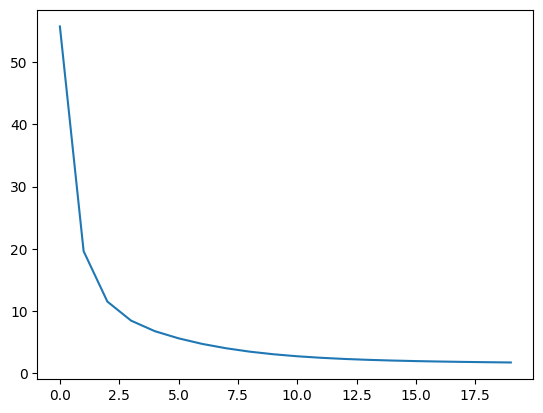

In [582]:
plt.plot(training_loss)

**Graph of final total loss function expression tree**

In [583]:
# draw_graph(loss)